In [2]:
!pip install pandas

In [11]:
import os
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import *

# Get Dataset

In [12]:
#ssl error solution
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

dataset_path = 'datasets/dataset'

data_dir = pathlib.Path(dataset_path)
if not data_dir.exists():
    tf.keras.utils.get_file('dataset.zip',origin="https://cloud.tsinghua.edu.cn/f/db9d627e4b5d4978973f/?dl=1",extract=True,cache_dir='.')


In [13]:
dataset_path = 'datasets/dataset'
data_dir = pathlib.Path(dataset_path)
label_num = len(tf.io.gfile.listdir(data_dir))
labels = np.array(tf.io.gfile.listdir(data_dir))

# Data Processing

## Pre-functions

In [14]:
def getLabel(file_path):
    dirs = tf.strings.split(input=file_path,sep=os.path.sep)
    label = dirs[-2] # nearest sub_directories
    return label 

In [15]:
def getSpec(file_path):
    spec_img = tf.io.read_file(file_path)
    spec_img_tensor = tf.image.decode_png(spec_img,channels=3)
    spectrogram = tf.image.resize(spec_img_tensor,[192,192]) #resize
    spectrogram = spectrogram/255.0 #rescale
    return spectrogram

In [16]:
def getSpecLabelIndex(file_path):
    spectrogram = getSpec(file_path)
    label = getLabel(file_path)
    label_index = tf.argmax(label == labels)
    return spectrogram,label_index


## Split into Sets

In [17]:
filenames = tf.io.gfile.glob(str(data_dir)+'/*/*')

# get all distinct labels
filenames = tf.random.shuffle(filenames)
training_files = filenames[0:int(len(filenames)*0.8)]
valid_files = filenames[int(len(filenames)*0.8):int(len(filenames)*0.9)]
test_files = filenames[int(len(filenames)*0.9):len(filenames)]

In [18]:
def getPairs(files_path):
    files = tf.data.Dataset.from_tensor_slices(files_path)
    sl_pairs = files.map(map_func=getSpecLabelIndex)
    return sl_pairs

## Extract Spectogram-label Pairs

In [19]:
train_dataset = getPairs(training_files)
valid_dataset = getPairs(valid_files)
test_dataset = getPairs(test_files)

## Show One Pic

In [20]:
!!pip install matplotlib -i https://pypi.tuna.tsinghua.edu.cn/simple

['Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple',
 'Requirement already satisfied: matplotlib in /usr/local/lib/python3.6/dist-packages (3.3.4)',
 'Requirement already satisfied: numpy>=1.15 in /usr/local/lib/python3.6/dist-packages (from matplotlib) (1.19.5)',
 'Requirement already satisfied: pillow>=6.2.0 in /usr/local/lib/python3.6/dist-packages (from matplotlib) (8.4.0)',
 'Requirement already satisfied: kiwisolver>=1.0.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib) (1.3.1)',
 'Requirement already satisfied: cycler>=0.10 in /usr/local/lib/python3.6/dist-packages (from matplotlib) (0.11.0)',
 'Requirement already satisfied: python-dateutil>=2.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib) (2.8.2)',
 'Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.3 in /usr/local/lib/python3.6/dist-packages (from matplotlib) (3.0.6)',
 'Requirement already satisfied: six>=1.5 in /usr/local/lib/python3.6/dist-packages (from python-dat

Text(0.5, 1.0, '11')

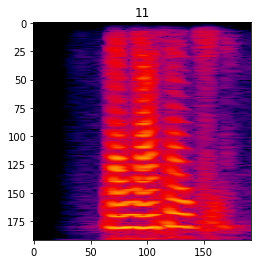

In [21]:
import matplotlib.pyplot as plt
spec_example,label_example =getSpecLabelIndex(filenames[0])
plt.imshow(spec_example)
plt.title(str(label_example.numpy())[0:])

batch training and validation sets

In [22]:
batch_size = 20
batch_train_dataset = train_dataset.batch(batch_size)
batch_valid_dataset = valid_dataset.batch(batch_size)
for example,_ in train_dataset.take(1):
    input_shape = example.shape

In [23]:
batch_train_dataset = batch_train_dataset.cache().prefetch(tf.data.AUTOTUNE)
batch_valid_dataset = batch_valid_dataset.cache().prefetch(tf.data.AUTOTUNE)

## Model

In [24]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_dataset.map(map_func=lambda spec, label: spec))

tf.keras.backend.clear_session()
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32,32),
    norm_layer,
    layers.Conv2D(32,3,strides=(1,1),padding='valid',activation='sigmoid'),
    layers.Conv2D(64,3,strides=(1,1),padding='valid',activation='sigmoid'),
    layers.MaxPool2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128,activation='sigmoid'),
    layers.Dropout(0.2),
    layers.Dense(label_num)]) #output layer

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 3)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [25]:
model.compile(optimizer=optimizers.Nadam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],)
EPOCHS = 20
history = model.fit(batch_train_dataset,validation_data=batch_valid_dataset,epochs=EPOCHS,callbacks=callbacks.EarlyStopping(verbose=1,patience=2),)

Epoch 1/20
99/99 [==============================] - 6s 21ms/step - loss: 3.3758 - accuracy: 0.0385 - val_loss: 3.1945 - val_accuracy: 0.0283
Epoch 2/20
99/99 [==============================] - 1s 10ms/step - loss: 3.2543 - accuracy: 0.0405 - val_loss: 3.1904 - val_accuracy: 0.0283
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 3.2313 - accuracy: 0.0441 - val_loss: 3.1912 - val_accuracy: 0.0283
Epoch 4/20
99/99 [==============================] - 1s 11ms/step - loss: 3.2512 - accuracy: 0.0395 - val_loss: 3.1907 - val_accuracy: 0.0283
Epoch 00004: early stopping


In [26]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_dataset.map(map_func=lambda spec, label: spec))

tf.keras.backend.clear_session()
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32,32),
    norm_layer,
    layers.Conv2D(32,3,strides=(1,1),padding='valid',activation='relu'),
    layers.Conv2D(64,3,strides=(1,1),padding='valid',activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128,activation='sigmoid'),
    layers.Dropout(0.2),
    layers.Dense(label_num)]) #output layer

In [27]:
model2.compile(optimizer=optimizers.Nadam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],)
EPOCHS = 20
history2 = model2.fit(batch_train_dataset,validation_data=batch_valid_dataset,epochs=EPOCHS,callbacks=callbacks.EarlyStopping(verbose=1,patience=2),)

Epoch 1/20
99/99 [==============================] - 2s 12ms/step - loss: 3.1161 - accuracy: 0.0825 - val_loss: 2.8922 - val_accuracy: 0.1619
Epoch 2/20
99/99 [==============================] - 1s 11ms/step - loss: 2.4899 - accuracy: 0.2866 - val_loss: 2.4440 - val_accuracy: 0.2834
Epoch 3/20
99/99 [==============================] - 1s 10ms/step - loss: 1.8749 - accuracy: 0.5073 - val_loss: 2.2042 - val_accuracy: 0.3603
Epoch 4/20
99/99 [==============================] - 1s 10ms/step - loss: 1.3491 - accuracy: 0.6911 - val_loss: 2.0298 - val_accuracy: 0.4170
Epoch 5/20
99/99 [==============================] - 1s 10ms/step - loss: 0.9574 - accuracy: 0.8309 - val_loss: 1.9297 - val_accuracy: 0.4737
Epoch 6/20
99/99 [==============================] - 1s 11ms/step - loss: 0.6580 - accuracy: 0.9058 - val_loss: 1.8596 - val_accuracy: 0.4615
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.4382 - accuracy: 0.9595 - val_loss: 1.8442 - val_accuracy: 0.4777
Epoch 8/20
99

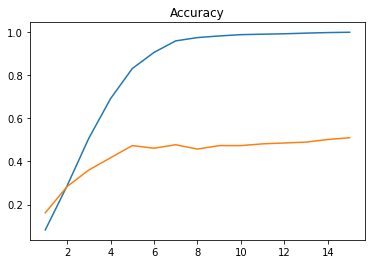

In [28]:
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
plt.plot(range(1,len(val_accuracy)+1),accuracy,label="training accuracy")
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label="validation accuracy")
plt.title("Accuracy")
plt.show()

seems like data augmentation is needed

In [29]:
preprocessing_layers = Sequential([
    layers.experimental.preprocessing.RandomFlip(input_shape=(192,192,3)),
    layers.experimental.preprocessing.RandomRotation(0.07),
    layers.experimental.preprocessing.RandomZoom(0.07),
])


norm_layer = layers.Normalization()
norm_layer.adapt(data=train_dataset.map(map_func=lambda spec, label: spec))

tf.keras.backend.clear_session()
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing_layers,
    norm_layer,
    layers.Resizing(32,32),
    layers.Conv2D(32,3,strides=(1,1),padding='same',activation='relu'),
    layers.Conv2D(32,3,strides=(1,1),padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(64,3,strides=(1,1),padding='same',activation='relu'),
    layers.Conv2D(64,3,strides=(1,1),padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512,activation='sigmoid'),
    layers.Dense(label_num)]) #output layer



model3.compile(optimizer=optimizers.Nadam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],)
EPOCHS = 20
history3 = model3.fit(batch_train_dataset,validation_data=batch_valid_dataset,epochs=EPOCHS)

Epoch 1/20
99/99 [==============================] - 4s 20ms/step - loss: 3.2945 - accuracy: 0.0709 - val_loss: 3.1177 - val_accuracy: 0.0810
Epoch 2/20
99/99 [==============================] - 2s 19ms/step - loss: 2.8656 - accuracy: 0.1499 - val_loss: 2.9093 - val_accuracy: 0.1053
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 2.5357 - accuracy: 0.2238 - val_loss: 2.5510 - val_accuracy: 0.1619
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 2.3356 - accuracy: 0.2861 - val_loss: 2.4857 - val_accuracy: 0.2267
Epoch 5/20
99/99 [==============================] - 2s 20ms/step - loss: 2.1960 - accuracy: 0.3144 - val_loss: 2.1488 - val_accuracy: 0.2794
Epoch 6/20
99/99 [==============================] - 2s 19ms/step - loss: 2.0375 - accuracy: 0.3590 - val_loss: 2.0334 - val_accuracy: 0.3684
Epoch 7/20
99/99 [==============================] - 2s 17ms/step - loss: 1.9084 - accuracy: 0.3959 - val_loss: 2.0442 - val_accuracy: 0.3320
Epoch 8/20
99

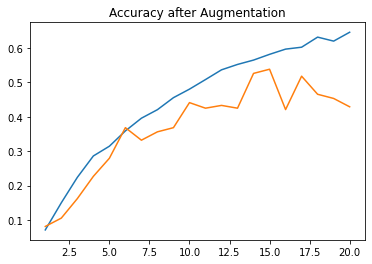

In [30]:
accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']
plt.plot(range(1,len(val_accuracy)+1),accuracy,label="training accuracy")
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label="validation accuracy")
plt.title("Accuracy after Augmentation")
plt.show()

# apply grid search for hyperparamter

In [32]:
unit_grids = range(32,128,32)
max_val_accuracy_unit_grid = 32
max_val_accracy_unit = 0

for unit_grid in unit_grids:
    preprocessing_layers = Sequential([
        layers.experimental.preprocessing.RandomFlip(input_shape=(192,192,3)),
        layers.experimental.preprocessing.RandomRotation(0.07),
        layers.experimental.preprocessing.RandomZoom(0.07),
    ])


    norm_layer = layers.Normalization()
    norm_layer.adapt(data=train_dataset.map(map_func=lambda spec, label: spec))

    tf.keras.backend.clear_session()
    model_search = models.Sequential([
        layers.Input(shape=input_shape),
        preprocessing_layers,
        norm_layer,
        layers.Resizing(unit_grid,unit_grid),
        layers.Conv2D(unit_grid,3,strides=(1,1),padding='same',activation='relu'),
        layers.Conv2D(unit_grid,3,strides=(1,1),padding='same',activation='relu'),
        layers.MaxPool2D(),
        layers.BatchNormalization(),
        layers.Conv2D(unit_grid*2,3,strides=(1,1),padding='same',activation='relu'),
        layers.Conv2D(unit_grid*2,3,strides=(1,1),padding='same',activation='relu'),
        layers.MaxPool2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(unit_grid*8,activation='sigmoid'),
        layers.Dense(label_num)]) #output layer


    model_search.compile(optimizer=optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'],)
    EPOCHS = 10
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history_search = model_search.fit(batch_train_dataset,validation_data=batch_valid_dataset,epochs=EPOCHS,callbacks=[stop_early,])
    val_accuracy_unit = history_search.history['val_accuracy']
    if max(val_accuracy_unit) > max_val_accracy_unit:
        max_val_accuracy_unit_grid = unit_grid
        max_val_accracy_unit = max(val_accuracy_unit)
    print("Current grid : %d ; max_val_accuracy_grid : %d ; Val_accuracy: %f" % (unit_grid,max_val_accuracy_unit_grid,max_val_accracy_unit))
    model_search.save('current_search_model.h5')
print("Final max_val_accuracy_grid : %d ; Val_accuracy: %f" % (max_val_accuracy_unit_grid,max_val_accracy_unit))

Epoch 1/10
99/99 [==============================] - 3s 16ms/step - loss: 3.2799 - accuracy: 0.0587 - val_loss: 3.1572 - val_accuracy: 0.0688
Epoch 2/10
99/99 [==============================] - 1s 14ms/step - loss: 2.9593 - accuracy: 0.1220 - val_loss: 3.1911 - val_accuracy: 0.0324
Epoch 3/10
99/99 [==============================] - 1s 14ms/step - loss: 2.7071 - accuracy: 0.1858 - val_loss: 2.8082 - val_accuracy: 0.0850
Epoch 4/10
99/99 [==============================] - 2s 16ms/step - loss: 2.4712 - accuracy: 0.2415 - val_loss: 2.5707 - val_accuracy: 0.1700
Epoch 5/10
99/99 [==============================] - 2s 18ms/step - loss: 2.3072 - accuracy: 0.2967 - val_loss: 2.3870 - val_accuracy: 0.2389
Epoch 6/10
99/99 [==============================] - 2s 18ms/step - loss: 2.2111 - accuracy: 0.3230 - val_loss: 2.1754 - val_accuracy: 0.2874
Epoch 7/10
99/99 [==============================] - 2s 18ms/step - loss: 2.0666 - accuracy: 0.3484 - val_loss: 2.1828 - val_accuracy: 0.2753
Epoch 8/10
99

In [34]:
epoch_grids = range(10,51,10)
max_val_accuracy_epoch_grid = 10
max_val_accuracy_epoch = 0

for epoch_grid in epoch_grids:
    preprocessing_layers = Sequential([
        layers.experimental.preprocessing.RandomFlip(input_shape=(192,192,3)),
        layers.experimental.preprocessing.RandomRotation(0.07),
        layers.experimental.preprocessing.RandomZoom(0.07),
    ])


    norm_layer = layers.Normalization()
    norm_layer.adapt(data=train_dataset.map(map_func=lambda spec, label: spec))

    tf.keras.backend.clear_session()
    model_search = models.Sequential([
        layers.Input(shape=input_shape),
        preprocessing_layers,
        norm_layer,
        layers.Resizing(max_val_accuracy_unit_grid,max_val_accuracy_unit_grid),
        layers.Conv2D(max_val_accuracy_unit_grid,3,strides=(1,1),padding='same',activation='relu'),
        layers.Conv2D(max_val_accuracy_unit_grid,3,strides=(1,1),padding='same',activation='relu'),
        layers.MaxPool2D(),
        layers.BatchNormalization(),
        layers.Conv2D(max_val_accuracy_unit_grid*2,3,strides=(1,1),padding='same',activation='relu'),
        layers.Conv2D(max_val_accuracy_unit_grid*2,3,strides=(1,1),padding='same',activation='relu'),
        layers.MaxPool2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(max_val_accuracy_unit_grid*8,activation='sigmoid'),
        layers.Dense(label_num)]) #output layer


    model_search.compile(optimizer=optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'],)
    EPOCHS = epoch_grid

    history_search = model_search.fit(batch_train_dataset,validation_data=batch_valid_dataset,epochs=EPOCHS)
    val_accuracy = history_search.history['val_accuracy']
    if val_accuracy[-1] > max_val_accuracy_epoch:
        max_val_accuracy_epoch_grid = epoch_grid
        max_val_accuracy_epoch = val_accuracy[-1]
    print("Current grid : %d ; max_val_accuracy_grid : %d ; Val_accuracy: %f" % (epoch_grid,max_val_accuracy_epoch_grid,max_val_accuracy_epoch))
    model_search.save('current_search_model.h5')
print("Final max_val_accuracy_grid : %d ; Val_accuracy: %f" % (max_val_accuracy_epoch_grid,max_val_accuracy_epoch))

Epoch 1/10
99/99 [==============================] - 3s 16ms/step - loss: 3.2129 - accuracy: 0.0770 - val_loss: 3.0414 - val_accuracy: 0.0769
Epoch 2/10
99/99 [==============================] - 1s 13ms/step - loss: 2.8156 - accuracy: 0.1468 - val_loss: 2.6903 - val_accuracy: 0.1741
Epoch 3/10
99/99 [==============================] - 1s 14ms/step - loss: 2.5685 - accuracy: 0.2081 - val_loss: 2.4187 - val_accuracy: 0.2024
Epoch 4/10
99/99 [==============================] - 1s 13ms/step - loss: 2.3792 - accuracy: 0.2522 - val_loss: 2.3200 - val_accuracy: 0.2308
Epoch 5/10
99/99 [==============================] - 2s 18ms/step - loss: 2.2264 - accuracy: 0.3084 - val_loss: 2.5133 - val_accuracy: 0.1781
Epoch 6/10
99/99 [==============================] - 2s 18ms/step - loss: 2.1089 - accuracy: 0.3438 - val_loss: 2.5719 - val_accuracy: 0.1660
Epoch 7/10
99/99 [==============================] - 2s 18ms/step - loss: 1.9800 - accuracy: 0.3828 - val_loss: 1.9103 - val_accuracy: 0.3684
Epoch 8/10
99

## Now fit the fine-tuned model again

In [35]:
preprocessing_layers = Sequential([
    layers.experimental.preprocessing.RandomFlip(input_shape=(192,192,3)),
    layers.experimental.preprocessing.RandomRotation(0.07),
    layers.experimental.preprocessing.RandomZoom(0.07),
])


norm_layer = layers.Normalization()
norm_layer.adapt(data=train_dataset.map(map_func=lambda spec, label: spec))

tf.keras.backend.clear_session()
best_model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing_layers,
    norm_layer,
    layers.Resizing(max_val_accuracy_unit_grid,max_val_accuracy_unit_grid),
    layers.Conv2D(max_val_accuracy_unit_grid,3,strides=(1,1),padding='same',activation='relu'),
    layers.Conv2D(max_val_accuracy_unit_grid,3,strides=(1,1),padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(max_val_accuracy_unit_grid*2,3,strides=(1,1),padding='same',activation='relu'),
    layers.Conv2D(max_val_accuracy_unit_grid*2,3,strides=(1,1),padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(max_val_accuracy_unit_grid*8,activation='sigmoid'),
    layers.Dense(label_num)]) #output layer


best_model.compile(optimizer=optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],)
EPOCHS = max_val_accuracy_epoch_grid
history_best_model = best_model.fit(batch_train_dataset,validation_data=batch_valid_dataset,epochs=EPOCHS)
val_accuracy_unit = history_search.history['val_accuracy']

Epoch 1/30
99/99 [==============================] - 3s 16ms/step - loss: 3.2395 - accuracy: 0.0689 - val_loss: 3.0804 - val_accuracy: 0.0729
Epoch 2/30
99/99 [==============================] - 1s 13ms/step - loss: 2.8574 - accuracy: 0.1352 - val_loss: 2.7875 - val_accuracy: 0.1215
Epoch 3/30
99/99 [==============================] - 1s 13ms/step - loss: 2.5856 - accuracy: 0.2030 - val_loss: 2.5959 - val_accuracy: 0.2146
Epoch 4/30
99/99 [==============================] - 1s 13ms/step - loss: 2.3924 - accuracy: 0.2719 - val_loss: 2.5430 - val_accuracy: 0.1579
Epoch 5/30
99/99 [==============================] - 2s 18ms/step - loss: 2.2305 - accuracy: 0.3058 - val_loss: 2.1745 - val_accuracy: 0.3158
Epoch 6/30
99/99 [==============================] - 2s 19ms/step - loss: 2.1180 - accuracy: 0.3367 - val_loss: 2.1106 - val_accuracy: 0.3482
Epoch 7/30
99/99 [==============================] - 2s 18ms/step - loss: 1.9889 - accuracy: 0.3762 - val_loss: 2.0530 - val_accuracy: 0.3482
Epoch 8/30
99

## Check performance

In [36]:
test_specs = []
test_labels = []

for spec, label in test_dataset:
  test_specs.append(spec.numpy())
  test_labels.append(label.numpy())

test_specs = np.array(test_specs)
test_labels = np.array(test_labels)

In [37]:
label_predict = np.argmax(best_model.predict(test_specs),axis=1)
label_real = test_labels

test_accuracy = sum(label_predict == label_real) / len(label_real)

print("Test Accuracy: %f" % (test_accuracy))

Test Accuracy: 0.542510


# Inplement keras.tuner

In [22]:
!pip install keras_tuner -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [23]:
import keras_tuner as kt

In [24]:
tuner_train_files = filenames[0:int(len(filenames)*0.8)]
tuner_test_files = filenames[int(len(filenames)*0.8):len(filenames)]
tuner_train_dataset = getPairs(tuner_train_files)
tuner_test_dataset = getPairs(tuner_test_files)

tuner_train_specs = []
tuner_train_labelsid = []
for i in tuner_train_dataset.as_numpy_iterator():
    tuner_train_specs.append(i[0])
    tuner_train_labelsid.append(i[1])
tuner_train_specs = np.array(tuner_train_specs)
tuner_train_labelsid = np.array(tuner_train_labelsid)

tuner_test_specs = []
tuner_test_labelsid = []
for i in tuner_test_dataset.as_numpy_iterator():
    tuner_test_specs.append(i[0])
    tuner_test_labelsid.append(i[1])
tuner_test_specs = np.array(tuner_test_specs)
tuner_test_labelsid = np.array(tuner_test_labelsid)

In [25]:
for example,_ in tuner_train_dataset.take(1):
    input_shape = example.shape

In [26]:
tf.keras.backend.clear_session()

def model_optimizer(hb):
    preprocessing_layers = Sequential([
    layers.experimental.preprocessing.RandomFlip(input_shape=(192,192,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),])

    norm_layer = layers.Normalization()
    norm_layer.adapt(data=tuner_train_dataset.map(map_func=lambda spec, label: spec))


    model = Sequential([
        layers.Input(shape=input_shape),
        preprocessing_layers,
        norm_layer,
        layers.Resizing(32,32),])

    hb_unit = hb.Int('unit',min_value=32,max_value=512,step=32)

    model.add(layers.Conv2D(hb_unit,3,strides=(1,1),padding='same',activation='relu'))
    model.add(layers.Conv2D(hb_unit,3,strides=(1,1),padding='same',activation='relu'))
    model.add(layers.MaxPool2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(hb_unit*2,3,strides=(1,1),padding='same',activation='relu'))
    model.add(layers.Conv2D(hb_unit*2,3,strides=(1,1),padding='same',activation='relu'))
    model.add(layers.MaxPool2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(hb_unit*8,activation='sigmoid'))
    model.add(layers.Dense(label_num)) #output layer

    model.compile(optimizer=optimizers.Nadam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],)
    return model

In [28]:
tuner = kt.Hyperband(model_optimizer,objective='val_accuracy',max_epochs=20,project_name='search_hyper')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(tuner_train_specs, tuner_train_labelsid, epochs=50, validation_split=0.2, callbacks=[stop_early])
# Get the optimal hyperparameters

INFO:tensorflow:Reloading Oracle from existing project ./search_hyper/oracle.json
INFO:tensorflow:Reloading Tuner from ./search_hyper/tuner0.json

Search: Running Trial #21

Hyperparameter    |Value             |Best Value So Far 
unit              |480               |96                
tuner/epochs      |7                 |20                
tuner/initial_e...|0                 |7                 
tuner/bracket     |1                 |2                 
tuner/round       |0                 |2                 

Epoch 1/7


ResourceExhaustedError:  failed to allocate memory
	 [[node Nadam/Nadam/update_12/mul (defined at /usr/local/lib/python3.6/dist-packages/keras_tuner/engine/hypermodel.py:137) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_126523]

Function call stack:
train_function


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
tuner.results_summary()

Results summary
Results in ./search_hyper3
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
unit: 0.25000000000000006
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.13417720794677734
Trial summary
Hyperparameters:
unit: 0.40000000000000013
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.12911392748355865
Trial summary
Hyperparameters:
unit: 0.20000000000000004
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.12911392748355865
Trial summary
Hyperparameters:
unit: 0.5000000000000001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.1265822798013687
Trial summary
Hyperparameters:
unit: 0.45000000000000007
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.11898734420537949
Trial summary
Hyperparameters:
unit: 0.30000000000000004
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2


## Find Best Epoch

In [ ]:
bestpara_model = tuner.hypermodel.build(best_hps)
history = bestpara_model.fit(tuner_train_specs, tuner_train_labelsid,epochs=50,validation_split=0.2)

val_accuracies = history.history['val_accuracy']
best_epoch = val_accuracies.index(max(val_accuracies)) + 1
print("Best Epoch %d" % (best_epoch,) )

Epoch 1/50
50/50 [==============================] - 4s 36ms/step - loss: 3.3157 - accuracy: 0.0696 - val_loss: 3.1700 - val_accuracy: 0.0658
Epoch 2/50
50/50 [==============================] - 1s 28ms/step - loss: 2.9356 - accuracy: 0.1278 - val_loss: 3.0093 - val_accuracy: 0.1190
Epoch 3/50
50/50 [==============================] - 1s 28ms/step - loss: 2.6000 - accuracy: 0.2196 - val_loss: 2.9743 - val_accuracy: 0.1215
Epoch 4/50
50/50 [==============================] - 1s 29ms/step - loss: 2.4520 - accuracy: 0.2570 - val_loss: 2.6824 - val_accuracy: 0.1873
Epoch 5/50
50/50 [==============================] - 1s 28ms/step - loss: 2.3071 - accuracy: 0.2994 - val_loss: 2.5516 - val_accuracy: 0.1975
Epoch 6/50
50/50 [==============================] - 1s 28ms/step - loss: 2.1477 - accuracy: 0.3259 - val_loss: 2.5479 - val_accuracy: 0.1949
Epoch 7/50
50/50 [==============================] - 1s 28ms/step - loss: 2.0371 - accuracy: 0.3759 - val_loss: 2.3042 - val_accuracy: 0.2684
Epoch 8/50
50

In [ ]:
bestmodel = tuner.hypermodel.build(best_hps)

# Retrain the model
best_history = bestmodel.fit(tuner_train_specs, tuner_train_labelsid, epochs=best_epoch, validation_split=0.2)

Epoch 1/50
50/50 [==============================] - 4s 35ms/step - loss: 3.2954 - accuracy: 0.0715 - val_loss: 3.1687 - val_accuracy: 0.0684
Epoch 2/50
50/50 [==============================] - 1s 24ms/step - loss: 2.9055 - accuracy: 0.1430 - val_loss: 3.0549 - val_accuracy: 0.1291
Epoch 3/50
50/50 [==============================] - 1s 25ms/step - loss: 2.6014 - accuracy: 0.2032 - val_loss: 3.0842 - val_accuracy: 0.1139
Epoch 4/50
50/50 [==============================] - 1s 29ms/step - loss: 2.3775 - accuracy: 0.2804 - val_loss: 3.8777 - val_accuracy: 0.0734
Epoch 5/50
50/50 [==============================] - 1s 29ms/step - loss: 2.2271 - accuracy: 0.3247 - val_loss: 2.8193 - val_accuracy: 0.1620
Epoch 6/50
50/50 [==============================] - 1s 28ms/step - loss: 2.0763 - accuracy: 0.3582 - val_loss: 2.7350 - val_accuracy: 0.2076
Epoch 7/50
50/50 [==============================] - 1s 28ms/step - loss: 1.9866 - accuracy: 0.3943 - val_loss: 2.4610 - val_accuracy: 0.2405
Epoch 8/50
50

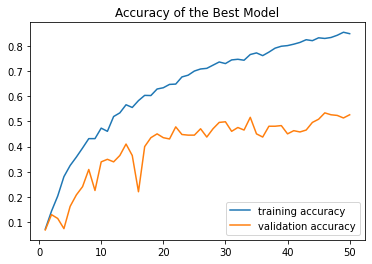

In [ ]:
accuracy = best_history.history['accuracy']
val_accuracy = best_history.history['val_accuracy']
plt.plot(range(1,len(val_accuracy)+1),accuracy,label="training accuracy")
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label="validation accuracy")
plt.legend(loc='lower right')
plt.title("Accuracy of the Best Model")
plt.show()

In [ ]:
eval_result = bestmodel.evaluate(tuner_test_specs, tuner_test_labelsid)
print("[test loss, test accuracy]:", eval_result)

16/16 [==============================] - 0s 9ms/step - loss: 1.7956 - accuracy: 0.4939
[test loss, test accuracy]: [1.7956151962280273, 0.49392712116241455]
